# Auto-Encoder 빌딩 연습

_야호 오토인코더다ㅠㅠ_

오토인코더는 신경망의 한 종류로서 입력 데이터를 코드(code)라고 부르는 은닉층으로 인코딩하는 인코더(Encoder)와 인코딩된 code를 다시 디코딩하는 디코더(Decoder)로 구성된 모형이다. 인코딩은 원래 데이터를 차원 축소하는 것을 의미하고, 디코딩은 차원 축소된 데이터를 다시 원래 데이터로 복원하는 것을 의미한다.

오토 인코더는 입력층보다 적은 수의 노드로 구성된 은닉층을 넣어 차원을 줄인다. 해당 은닉층을 code라고 부른다. 디코더는 code를 다시 원래 입력층과 같은 크기의 결과물로 출력한다. 

피처 데이터 X를 넣고 Y를 예측하는 것이아니라 X를 최대한 닮은 X'를 만드는 것이다. 입력과 출력이 같다고 보면 된다.

---
##### 이전 시계열 강의 내용  + 일부 인터넷 검색 결과 참조

시계열 데이터라면 인코더에 RNN이나 CNN을 넣을 수 있다.

PCA와 비슷하지만, 데이터의 비선형적인 관계도 고려하여 탐지를 수행한다는 점에서 강점을 가진다. 초기에는 PCA처럼 쓰려고 사용되었지만, 지금은 데이터 생성 모형으로도 쓰인다.

또한 GAN과 비슷한 점이 있는데, 다른 점이라하면 오토 인코더는 오리지널 데이터의 특징을 '잘' 살린 이미지를 만들어낸다. 하지만 적대적 생성 신경망(GAN)은 (오리지널 데이터처럼 생겼지만) 오리지널 데이터와 상관없는 새로운 형태의 데이터를 만들어낸다.

참조1: http://dagyeom.net/32/?q=YToxOntzOjEyOiJrZXl3b3JkX3R5cGUiO3M6MzoiYWxsIjt9&bmode=view&idx=7071265&t=board

참조2: https://a292run.tistory.com/entry/Anomaly-Detection-using-Autoencoders-1


$$ 수식 $$

---



##### 12.6.2 오토인코더 실습
오토인코더를 이용해 이미지 데이터의 노이즈를 없애본다.

# Random seed setting and Load Data, Libraries

일관된 결과를 위해 random seed를 0으로 고정한다.


In [1]:
import numpy as np
import tensorflow as tf
import keras

np.random.seed(0)
tf.random.set_seed(0)

# version check
print(np.__version__)
print(tf.__version__)
print(keras.__version__)

1.22.4
2.9.1
2.9.0


In [2]:
# data load
# 손글씨 데이터를 데려온다

from tensorflow.keras import datasets
(X_tn0, y_tn0), (X_te0, y_te0) = datasets.mnist.load_data()

In [3]:
# Origin data dimension check

print(X_tn0.shape)
print(y_tn0.shape)
print(X_te0.shape)
print(y_te0.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


6만 개와 1만개의 트레이닝, 테스트 데이터로 존재한다.

# Origin data visualization

오리지널 데이터 일부 10개를 가져와서 그린다. 서브플롯을 설정해서 그린다.

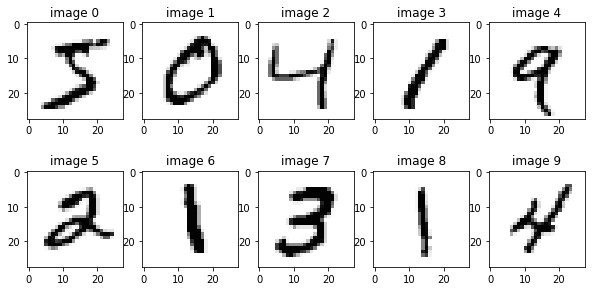

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,5))
for i in range(2*5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_tn0[i].reshape((28,28)), cmap = 'Greys')
    plt.title("image {}".format(i))

plt.show()

타겟은 X자신이다. y를 따로 체크하지 않는다.

# Rescaling feature and add noise

## Rescaling feature data
데이터는 (이미지 개수, 행, 열) 형태로, 3차원이다.
합성곱 신경망에 넣기 위해서는 4차원 형태로 구성되어야 한다.

합성곱 신경망 인풋 데이터의 차원은 (이미지 개수, 행, 열, 채널수) 의 형태로 구성되는데, 이때 채널은 보통 이미지의 RGB 값이 된다.

mnist 데이터는 채널 1개의 흑백 데이터이다. 따라서 채널수는 1이 된다.

In [5]:
# 트레이닝 피처 데이터의 차원 바꾸기 (이미지 개수, 행, 열, 채널수)
X_tn_re = X_tn0.reshape(60000, 28, 28, 1)

# 이미지 픽셀값이 0~255 사이에 분포해 있기 때문에 최댓값이 1이 되도록 조정하면 딥러닝 성능 향상에 도움이 된다
X_tn = X_tn_re / 255

# 바뀐 데이터 차원 확인
print(X_tn.shape)

(60000, 28, 28, 1)


In [6]:
# 같은 방식으로 테스트 피처 데이터 차원 reshape
X_te_re = X_te0.reshape(10000, 28, 28, 1)
X_te = X_te_re / 255
print(X_te.shape)

(10000, 28, 28, 1)


## Add noise feature data and scaling

노이즈 데이터를 따로 제공하지 않기 때문에, 직접 노이즈 데이터를 생성해본다.

오리지널 트레이닝 데이터에 랜덤값을 더하는 방식이다. 테스트 피처 데이터에 대해서도 같은 방법으로 랜덤값을 더할 것이다.

랜덤값은 np.random.uniform 함수로 균일 분포에서 추출하며, 랜덤 값은 -1부터 1사이값을 가진다. 또한 배열 사이즈를 트레이닝 데이터의 차원과 일치시켜 생성시켜야 한다.

노이즈 데이터는 생성되는 과정에서 픽셀값이 0이나 1이상이 되었을 가능성이 있기 때문에 이들의 스케일을 조정한다.

np.clip은 값의 범위를 조정할 수 있다. a_min, a_max는 해당 값보다 작거나 큰 데이터를 해당 값으로 변환한다.

In [7]:
X_tn_noise = X_tn + np.random.uniform(-1, 1, size = X_tn.shape)
X_te_noise = X_te + np.random.uniform(-1, 1, size = X_te.shape)

In [8]:
X_tn_ns = np.clip(X_tn_noise, a_min = 0, a_max = 1)
X_te_ns = np.clip(X_te_noise, a_min = 0, a_max = 1)

## Noise data visualizing to check

노이즈 데이터를 시각화하여본다. 오리지널 데이터를 그릴떄와 코드는 같지만 데이터만 X_train_ns로 바꾼다. 

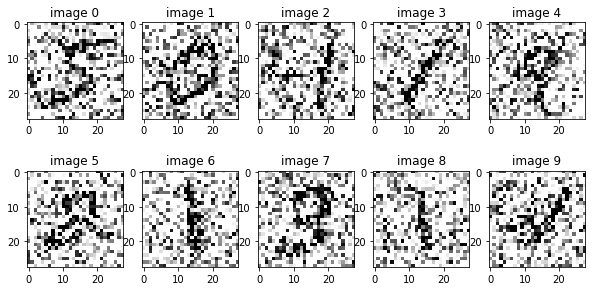

In [9]:
plt.figure(figsize = (10,5))
for i in range(2*5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_tn_ns[i].reshape((28,28)), cmap = 'Greys')
    plt.title("image {}".format(i))

plt.show()